# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IMT2118 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2024-1**<br>
**Profesora:** Paula Aguirre <br>
**Ayudante:** Diego Pizarro <br>
**Integrantes:** Alu "Cachetes" Palu,Bastian Baez Oses
<br>





---

In [88]:
import geopandas as gpd
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import pandas as pd
import folium
import os
import requests
import rasterio
import rasterio.mask
import seaborn as sns

In [2]:
#Inicializamos GEE
ee.Authenticate();
ee.Initialize(project='ee-bastianbaezos') #use su código de proyecto

In [3]:
# Funcion sacada de la ay. 4
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True, show=False).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [4]:
def getAOI(dat,crs=4326):
    aoi_coords = list(dat.geometry.unary_union.exterior.coords)
    aoi = ee.Geometry.Polygon(aoi_coords)
    return aoi

# La siguiente función fue sacada de:
# https://github.com/gee-community/geemap/issues/1095#issuecomment-1151812523
def fmask(image):
    # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).updateMask(qaMask)

def get_images(year_init, year_end, aoi):
    # Funcion creada usando de base la de la ayudantia 4
    years = list(range(year_init, year_end + 1))
    annual_imgs = {year: '' for year in years}

    for year in years:
        startDate = f'{year}-01-01'
        endDate = f'{year}-12-31'

        sentinelImageCollection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(aoi).filterDate(startDate, endDate)

        # Aplicamos fmask
        sentinelImageCollection = sentinelImageCollection.map(fmask)

        bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']

        # Seleccionamos las bandas de interés
        sentinelImageCollection = sentinelImageCollection.select(bandas)

        # Geomedian ee.Reducer.geometricMedian()
        image = sentinelImageCollection.reduce(ee.Reducer.geometricMedian(numX=6)).clip(aoi)

        # Cambiar nombre de las bandas a "bandas"
        image = image.rename(bandas)

        # Agregar imagen al diccionario
        annual_imgs[year] = image

    return annual_imgs

In [5]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

#Codigo obtenido de https://github.com/amasud08/Project_MRes/blob/main/notebooks/3_image_statistics.ipynb
#modificado para su uso en esta parte
def indices(img):
    
    #bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
    img = img.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"])
    
    # calculate ndvi
    ndvi = img.normalizedDifference(["NIR", "Red"]).rename('NDVI')

    img = img.addBands(ndvi)
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    img.addBands(ibi)
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")

    img = img.addBands(ENDISI)
    
    return  img

# Comunas

In [6]:
# Nuestro crs
n_crs = 4326

In [58]:
# obtener poligonos de comunas
comunas=gpd.read_file('Datos\R13\COMUNA_C17.shp')
display(comunas.head(5))
comunas = comunas.to_crs(epsg=n_crs)

# Crs de las comunas
print(comunas.crs)

# imprimir nombre de las comunas, para seleccionar la que queremos
print(comunas['NOM_COMUNA'].unique())

REGION                        NOM_REGION PROVINCIA NOM_PROVIN COMUNA  \
0     13  REGIÓN METROPOLITANA DE SANTIAGO       134      MAIPO  13404   
1     13  REGIÓN METROPOLITANA DE SANTIAGO       134      MAIPO  13402   
2     13  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  13124   
3     13  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  13103   
4     13  REGIÓN METROPOLITANA DE SANTIAGO       133  CHACABUCO  13301   

    NOM_COMUNA  SHAPE_Leng  SHAPE_Area  \
0        PAINE    1.625330    0.066035   
1         BUIN    0.884164    0.021166   
2     PUDAHUEL    0.720176    0.019124   
3  CERRO NAVIA    0.170180    0.001076   
4       COLINA    1.692007    0.093820   

                                            geometry  
0  POLYGON ((-70.61889 -33.73808, -70.61811 -33.7...  
1  POLYGON ((-70.63192 -33.64634, -70.63207 -33.6...  
2  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...  
3  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
4  POLYGON ((-70.59630 -32.95138, -70.59673 -32.9...

EPSG:4326
['PAINE' 'BUIN' 'PUDAHUEL' 'CERRO NAVIA' 'COLINA' 'TILTIL' 'LAMPA'
 'HUECHURABA' 'CONCHALÍ' 'MARÍA PINTO' 'CURACAVÍ' 'LA PINTANA' 'EL BOSQUE'
 'ESTACIÓN CENTRAL' 'PEDRO AGUIRRE CERDA' 'RECOLETA' 'INDEPENDENCIA'
 'ISLA DE MAIPO' 'LO ESPEJO' 'LA CISTERNA' 'LA FLORIDA' 'PEÑALOLÉN'
 'LAS CONDES' 'LA REINA' 'LO BARNECHEA' 'VITACURA' 'QUINTA NORMAL'
 'LO PRADO' 'CERRILLOS' 'MAIPÚ' 'MELIPILLA' 'MACUL' 'ÑUÑOA' 'PEÑAFLOR'
 'PADRE HURTADO' 'PUENTE ALTO' 'QUILICURA' 'RENCA' 'CALERA DE TANGO'
 'SAN BERNARDO' 'SAN JOSÉ DE MAIPO' 'PIRQUE' 'SAN JOAQUÍN' 'SAN MIGUEL'
 'SAN RAMÓN' 'LA GRANJA' 'PROVIDENCIA' 'SANTIAGO' 'EL MONTE' 'TALAGANTE'
 'SAN PEDRO' 'ALHUÉ']


In [59]:
# Escogemos las comunas que queremos
m_comunas = "CERRILLOS,CERRO NAVIA,CONCHALÍ,EL BOSQUE,ESTACIÓN CENTRAL,HUECHURABA,INDEPENDENCIA,LA CISTERNA,LA FLORIDA,LA GRANJA,LA PINTANA,LA REINA,LAS CONDES,LO ESPEJO,LO PRADO,MACUL,MAIPÚ,ÑUÑOA,PEDRO AGUIRRE CERDA,PEÑALOLÉN,PROVIDENCIA,PUDAHUEL,PUENTE ALTO,QUILICURA,QUINTA NORMAL,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUÍN,SAN MIGUEL,SAN RAMÓN,SANTIAGO,VITACURA,MÁCUL".split(',')
print(m_comunas)
print(len(m_comunas))

# Filtrar comunas
comunas = comunas[comunas.NOM_COMUNA.isin(m_comunas)]
# Resetear index
comunas.reset_index(drop=True, inplace=True)

# Columnas de interes
comunas = comunas[['NOM_COMUNA', 'geometry']]

# Visualizar comunas
display(comunas.head(5))

['CERRILLOS', 'CERRO NAVIA', 'CONCHALÍ', 'EL BOSQUE', 'ESTACIÓN CENTRAL', 'HUECHURABA', 'INDEPENDENCIA', 'LA CISTERNA', 'LA FLORIDA', 'LA GRANJA', 'LA PINTANA', 'LA REINA', 'LAS CONDES', 'LO ESPEJO', 'LO PRADO', 'MACUL', 'MAIPÚ', 'ÑUÑOA', 'PEDRO AGUIRRE CERDA', 'PEÑALOLÉN', 'PROVIDENCIA', 'PUDAHUEL', 'PUENTE ALTO', 'QUILICURA', 'QUINTA NORMAL', 'RECOLETA', 'RENCA', 'SAN BERNARDO', 'SAN JOAQUÍN', 'SAN MIGUEL', 'SAN RAMÓN', 'SANTIAGO', 'VITACURA', 'MÁCUL']
34


NOM_COMUNA                                           geometry
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [60]:
# Agregar "LO BARNECHEA"

m_comunas.append("LO BARNECHEA")

from obtener_barnechea import barnechea
barnechea()

# leer "LO BARNECHEA"
lo_barnechea = gpd.read_file('Datos\LO_BARNECHEA\lo_barnechea.gpkg')
lo_barnechea = lo_barnechea.to_crs(epsg=n_crs)

# Agregar "LO BARNECHEA" a comunas
comunas = comunas.append(lo_barnechea)

# Resetear index
comunas.reset_index(drop=True, inplace=True)

# Visualizar comunas
display(comunas.head(5))


Obteniendo la comuna de Lo Barnechea...


NOM_COMUNA                                           geometry
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [11]:
aoi = getAOI(comunas)
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -70.63216210499996,
              -33.64518685599995
            ],
            [
              -70.63238355099998,
              -33.64516477199993
            ],
            [
              -70.63277298299994,
              -33.645125933999964
            ],
            [
              -70.63346541499993,
              -33.64501785199997
            ],
            [
              -70.63362174499997,
              -33.64502476699994
            ],
            [
              -70.63386627099999,
              -33.645035581999934
            ],
            [
              -70.63444412799998,
              -33.64506114099993
            ],
            [
              -70.63544297899995,
              -33.64522284099996
            ],
            [
              -70.63646944199996,
              -33.645414725999956
            ],
            [
              -70.63647634299997,
              -33.645416015999956
            ],
            [
              -70.63670103599998,
              -33.64545696199997
            ],
            [
              -70.63734384599996,
              -33.645574102999944
            ],
            [
              -70.63762243499997,
              -33.64567071799996
            ],
            [
              -70.63835808699997,
              -33.645925844999965
            ],
            [
              -70.63900021899997,
              -33.64614853699993
            ],
            [
              -70.63919516899995,
              -33.64618787999996
            ],
            [
              -70.64015842299995,
              -33.646382277999976
            ],
            [
              -70.64224436399996,
              -33.64659764299995
            ],
            [
              -70.64232312999997,
              -33.646605774999955
            ],
            [
              -70.64265627899994,
              -33.64658580599996
            ],
            [
              -70.64332935699997,
              -33.64654546099996
            ],
            [
              -70.64408965199993,
              -33.646610083999974
            ],
            [
              -70.64412202999995,
              -33.64661894999995
            ],
            [
              -70.64418822599998,
              -33.646637075999934
            ],
            [
              -70.64438322699993,
              -33.64669047299998
            ],
            [
              -70.64459403399997,
              -33.646748197999955
            ],
            [
              -70.64479164999995,
              -33.64680231099993
            ],
            [
              -70.64480356299998,
              -33.64680429899994
            ],
            [
              -70.64522866399994,
              -33.64687523699996
            ],
            [
              -70.64523944499996,
              -33.64687703599998
            ],
            [
              -70.64527986199994,
              -33.646940564999966
            ],
            [
              -70.64532023999993,
              -33.64700207899995
            ],
            [
              -70.64557570299996,
              -33.647034832999964
            ],
            [
              -70.64601787699996,
              -33.64709152599994
            ],
            [
              -70.64617870199999,
              -33.647148984999944
            ],
            [
              -70.64637806999997,
              -33.64722021399996
            ],
            [
              -70.64677449099997,
              -33.64736184399993
            ],
            [
              -70.64693304799994,
              -33.64741849199993
            ],
            [
              -70.64696134899998,
              -33.647425331999955
            ],
            [
              -70.64716381799997,
              -

In [12]:
start_year = 2015
end_year = 2023

x,y =aoi.centroid().getInfo()["coordinates"]
dates=[start_year,end_year]
imagenes=get_images(start_year,end_year,aoi)
imagenes


{2015: <ee.image.Image at 0x201dc252b50>,
 2016: <ee.image.Image at 0x201dc289510>,
 2017: <ee.image.Image at 0x201dc28bbd0>,
 2018: <ee.image.Image at 0x201dc2c83d0>,
 2019: <ee.image.Image at 0x201dc2ca110>,
 2020: <ee.image.Image at 0x201df9d0390>,
 2021: <ee.image.Image at 0x201df9d1c50>,
 2022: <ee.image.Image at 0x201df9d3b90>,
 2023: <ee.image.Image at 0x201d6c86750>}

In [13]:
# Visualización de las imágenes
visualization_rgb = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}
fmap = folium.Map(location=[y,x], zoom_start=10)

for year in imagenes.keys():
    image = imagenes[year]
    fmap.add_ee_layer(image, visualization_rgb, name=str(year))

fmap.add_child(folium.LayerControl())
display(fmap)

# Pixeles muertos. Puede ser por valores de reflectancia fuera de rango.

In [14]:
## TIMELAPSE GIF RGB

# Codigo inspirado en ayudantia 4
video_args_rgb = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': 0.0,
    'max': 0.3,
    'bands': ['SR_B3', 'SR_B2', 'SR_B1']
}

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crear el gif
gif_url = timelapse_imagenes.getVideoThumbURL(video_args_rgb)
gif_url

# Codigo inspirado de https://book.geemap.org/chapters/09_timelapse.html

in_gif = r'imagenes-gif\timelapse.gif'
on_gif = r'imagenes-gif\timelapse_with_text.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='#ffffff',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)

geemap.show_image(on_gif)

geemap.download_file

Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/ca3ba6938ab1d500e4e960550647c6dc-e73583c502dabcb582e18b457bc22408:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse.gif
100%|██████████| 1.74M/1.74M [00:00<00:00, 1.88MB/s]


Output()

<function geemap.common.download_file(url=None, output=None, quiet=False, proxy=None, speed=None, use_cookies=True, verify=True, id=None, fuzzy=False, resume=False, unzip=True, overwrite=False)>

In [15]:
imagenes = {year: indices(img) for year, img in imagenes.items()}

# imprimir las bandas de la imagen
imagenes[start_year].bandNames().getInfo()

['Blue',
 'Green',
 'Red',
 'NIR',
 'SWIR1',
 'SWIR2',
 'NDVI',
 'swir_diff',
 'MNDWI',
 'blue_mean',
 'swir_mean',
 'mndwi_mean',
 'alpha',
 'ENDISI']

In [16]:
## CMAPS

# Lista de paleta de colores
smooth_colors = ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'] 

# Palette de colores
smooth_cmap = mcolors.LinearSegmentedColormap.from_list('smooth_cmap', ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'])


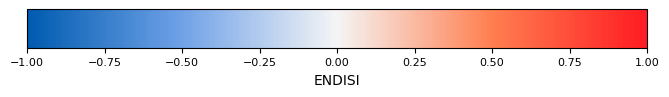

In [17]:
## COLORBAR ENDISI

vmin = -1
vmax = 1

# Crear una figura de matplotlib para el colorbar
fig, ax = plt.subplots(figsize=(8, 0.5))
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=smooth_cmap), 
                  cax=ax, orientation='horizontal')
cb.set_label('ENDISI', fontsize=10)
cb.ax.tick_params(labelsize=8)

# Guardar el colorbar como una imagen
colorbar_file_endisi = 'imagenes-gif/colorbar-endisi.png'
plt.savefig(colorbar_file_endisi, bbox_inches='tight', dpi=300)

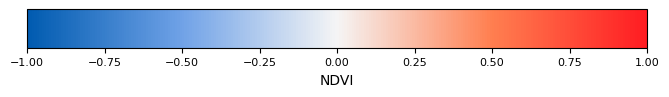

In [18]:
## COLORBAR NDVI

vmin = -1
vmax = 1

# Crear una figura de matplotlib para el colorbar
fig, ax = plt.subplots(figsize=(8, 0.5))
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=smooth_cmap), 
                  cax=ax, orientation='horizontal')
cb.set_label('NDVI', fontsize=10)
cb.ax.tick_params(labelsize=8)

# Guardar el colorbar como una imagen
colorbar_file_ndvi = 'imagenes-gif/colorbar-ndvi.png'
plt.savefig(colorbar_file_ndvi, bbox_inches='tight', dpi=300)

In [19]:
## TIMELAPSE GIF ENDISI

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crea el gif con las zonas y las imágenes de ENDISI
video_args = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': vmin,
    'max': vmax,
    'bands': ['ENDISI'],
    'palette': smooth_colors
}

gif_url = timelapse_imagenes.getVideoThumbURL(video_args)

in_gif = r'imagenes-gif\timelapse_ENDISI.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.show_image(in_gif)


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/1345c91da519b1a514bdef3f5f54d0ba-4411217ebdc8ae0cf6d47f96c5dc1ec9:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse_ENDISI.gif
100%|██████████| 1.84M/1.84M [00:01<00:00, 1.71MB/s]


Output()

In [20]:
# Agregar años al gif
on_gif = r'imagenes-gif\timelapse_ENDISI_text.gif'
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='white',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)
geemap.add_image_to_gif(in_gif=on_gif, out_gif=on_gif, in_image=colorbar_file_endisi, xy = ('55%', '80%'), image_size=(1200, 80))
geemap.show_image(on_gif)

Output()

In [21]:
## TIMELAPSE GIF NDVI

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crea el gif con las zonas y las imágenes de NDVI
video_args = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': vmin,
    'max': vmax,
    'bands': ['NDVI'],
    'palette': smooth_colors
}

gif_url = timelapse_imagenes.getVideoThumbURL(video_args)

in_gif = r'imagenes-gif\timelapse_NDVI.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.show_image(in_gif)


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/57874dbb9f16e3687eca59e2c392495f-435b78172f7986914c99a30b427e4580:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse_NDVI.gif
100%|██████████| 1.46M/1.46M [00:00<00:00, 1.65MB/s]


Output()

In [22]:
# Agregar años al gif
on_gif = r'imagenes-gif\timelapse_NDVI_text.gif'
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='white',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)
geemap.add_image_to_gif(in_gif=on_gif, out_gif=on_gif, in_image=colorbar_file_ndvi, xy = ('55%', '80%'), image_size=(1200, 80))
geemap.show_image(on_gif)

Output()

In [23]:
out_dir = os.path.join(os.getcwd(), 'imagenes-gif', 'rasters')
# Descargar rasters
for year, img in imagenes.items():
    continue # Borrar despues
    if year != 2018:
        print(f"Saltando {year}")
        continue
    print(f"Descargando {year}")
    url = img.getDownloadURL({
        'bands': ['ENDISI'],
        'region': aoi,
        'scale': 30,
        'format': 'GeoTIFF'
    })
    out_file = os.path.join(out_dir, f'{year}.tif')
    geemap.download_file(url, out_file, overwrite=True)
    

In [471]:
# Leer los archivos tif
rasters = [os.path.join(out_dir, f) for f in os.listdir(out_dir) if f.endswith('.tif')]
rasters.sort()

for r in rasters:
    with rasterio.open(r) as src:
        means_endisi = []

        for index, row in comunas.iterrows():
            geometry = [row['geometry']]
            out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
            out_image = out_image[0]  # Sólo una banda
            # Máscara de valores no válidos
            out_image = np.ma.masked_equal(out_image, src.nodata)
            # Calcular el promedio excluyendo valores nodata
            mean_endisi = out_image.mean()
            means_endisi.append(mean_endisi)
        comunas[f'mean_endisi_{os.path.basename(r).split(".")[0]}'] = means_endisi
        print(f'Termine el año {os.path.basename(r).split(".")[0]}')
        

Termine el año 2015
Termine el año 2016
Termine el año 2017
Termine el año 2018
Termine el año 2019
Termine el año 2020
Termine el año 2021
Termine el año 2022
Termine el año 2023


In [472]:
# Cargar los datos de criminalidad y calidad de vida urbana
ruta_cead_1 = r"Datos\CEAD\reportes-unidadTerritorial.xlsx"
cead_1 = pd.read_excel(ruta_cead_1, thousands='.', decimal=',')

# Convertir la columna "Unidad Territorial" a mayúsculas
cead_1['UNIDAD TERRITORIAL'] = cead_1['UNIDAD TERRITORIAL'].str.upper()

display(cead_1.head(5))

UNIDAD TERRITORIAL      2015      2016      2017      2018      2019  \
0               TOTAL PAÍS  889198.0  844796.0  850619.0  845158.0  873749.0   
1     REGIÓN METROPOLITANA  383483.0  357755.0  364268.0  367773.0  382671.0   
2    PROVINCIA DE SANTIAGO  297331.0  276814.0  280191.0  280241.0  291141.0   
3                 SANTIAGO   39847.0   37161.0   39595.0   38783.0   39912.0   
4                CERRILLOS    5686.0    5145.0    4932.0    5374.0    5783.0   

       2020      2021      2022      2023  
0  675008.0  666422.0  854545.0  885513.0  
1  279458.0  271680.0  342295.0  354671.0  
2  209809.0  202228.0  259963.0  271951.0  
3   24571.0   25212.0   36113.0   38491.0  
4    4132.0    3785.0    5125.0    5304.0

In [473]:
# Eliminar las filas que en la columna "Unidad Territorial" no estén en la lista de comunas
cead_1['UNIDAD TERRITORIAL'] = cead_1['UNIDAD TERRITORIAL'].map(str.strip)
cead_1 = cead_1[cead_1["UNIDAD TERRITORIAL"].isin(m_comunas)]
cead_1 = cead_1.reset_index(drop=True)
display(cead_1.head(5))

UNIDAD TERRITORIAL     2015     2016     2017     2018     2019     2020  \
0           SANTIAGO  39847.0  37161.0  39595.0  38783.0  39912.0  24571.0   
1          CERRILLOS   5686.0   5145.0   4932.0   5374.0   5783.0   4132.0   
2        CERRO NAVIA   4582.0   4601.0   4431.0   4892.0   5105.0   4432.0   
3           CONCHALÍ   5256.0   5141.0   5501.0   5962.0   6669.0   5308.0   
4          EL BOSQUE   7913.0   6971.0   7692.0   7732.0   7777.0   5658.0   

      2021     2022     2023  
0  25212.0  36113.0  38491.0  
1   3785.0   5125.0   5304.0  
2   4598.0   5467.0   6610.0  
3   4578.0   5404.0   5942.0  
4   5501.0   6130.0   6539.0

In [474]:
# Join de las cead_1 con las comunas
cead_comunas_1 = comunas.merge(cead_1, left_on='NOM_COMUNA', right_on='UNIDAD TERRITORIAL', how='inner')
cead_comunas_1 = cead_comunas_1.drop(columns=['UNIDAD TERRITORIAL'])
display(cead_comunas_1.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023     2015    2016    2017     2018     2019    2020  \
0         -0.014481  10406.0  9410.0  9534.0  10931.0  11669.0  8816.0   
1          0.258278   4582.0  4601.0  4431.0   4892.0   5105.0  4432.0   
2         -0.094749   6291.0  5521.0  5395.0   5196.0   5413.0  3773.0   
3          0.237533   5256.0  5141.0  5501.0   5962.0   6669.0  5308.0   
4          0.094690   8809.0  8197.0  7945.0   8216.0   8608.0  6618.0   

     2021     2022     2023  
0  8874.0  10716.0  11999.0  
1  4598.0   5467.0   6610.0  
2  3706.0   4371.0   4701.0  
3  4578.0   5404.0   5942.0  
4  6114.0   7271.0   7498.0

In [475]:
# Calcular la densidad de criminalidad por km²
for year in range(start_year, end_year + 1):
    cead_comunas_1[year] = cead_comunas_1[year] / (cead_comunas_1['geometry'].to_crs(epsg=32719).area / 10**6)

cead_comunas_1 = cead_comunas_1.rename(columns={year: str(year) for year in range(start_year, end_year + 1)})
display(cead_comunas_1.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023        2015        2016        2017        2018  \
0         -0.014481   52.753159   47.703943   48.332560   55.414644   
1          0.258278  412.891030  414.603149  399.284189  440.825605   
2         -0.094749  140.116659  122.966790  120.160447  115.728208   
3          0.237533  473.097396  462.746140  495.150072  536.645106   
4          0.094690  289.281193  269.183555  260.908057  269.807501   

         2019        2020        2021        2022        2023  
0   59.155930   44.692663   44.986693   54.324702   60.828864  
1  460.019361  399.374301  414.332815  492.639734  595.637213  
2  120.561353   84.034359   82.542098   97.353349  104.703292  
3  600.282826  477.777964  412.069992  486.419012  534.844887  
4  282.680498  217.330336  200.779341  238.774384  246.228900

In [476]:
# Promedio de criminalidad de los años 2015 a 2023
cead_comunas_1['mean_cead'] = cead_comunas_1[[str(year) for year in range(start_year, end_year + 1)]].mean(axis=1)

# Promedio endisi de los años 2015 a 2023
cead_comunas_1['mean_endisi'] = cead_comunas_1[[f'mean_endisi_{year}' for year in range(start_year, end_year + 1)]].mean(axis=1)

# Seleccionar columnas de interés
cead_comunas_1 = cead_comunas_1[['NOM_COMUNA', 'mean_cead', 'mean_endisi', 'geometry']]
display(cead_comunas_1.head(5))

NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...

In [477]:
# Cargar datos de calidad de vida urbana (ICVU)
gdf_icvu = gpd.read_file("Datos\CALIDAD\ICVU_2017.geojson")
columnas_icvu = ['nom_com', 'icvu_2017']
gdf_icvu = gdf_icvu[columnas_icvu]
gdf_icvu = gdf_icvu.rename(columns={'nom_com': 'NOM_COMUNA'})
gdf_icvu['NOM_COMUNA'] = gdf_icvu['NOM_COMUNA'].str.upper()
gdf_icvu = gdf_icvu[gdf_icvu['NOM_COMUNA'].isin(m_comunas)]
gdf_icvu = gdf_icvu.reset_index(drop=True)

# Corregir nombre de comuna
gdf_icvu.loc[gdf_icvu['NOM_COMUNA'] == 'MÁCUL', 'NOM_COMUNA'] = 'MACUL'
display(gdf_icvu.head(5))

NOM_COMUNA  icvu_2017
0         CERRILLOS       32.6
1       CERRO NAVIA       26.9
2          CONCHALÍ       30.7
3         EL BOSQUE       28.0
4  ESTACIÓN CENTRAL       33.4

In [478]:
# Join de las comunas con el ICVU
cead_comunas_1 = cead_comunas_1.merge(gdf_icvu, on='NOM_COMUNA', how='inner')
display(cead_comunas_1.head(5))

NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  icvu_2017  
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2  
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9  
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2  
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7  
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2

In [479]:
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

#librerías para regionalización

from libpysal import weights
#!pip install spopt
import spopt

In [480]:
cl_var = ['mean_cead', 'mean_endisi', 'icvu_2017']
cl_var_norm = [f'{var}_norm' for var in cl_var]

# Normalizar las variables con StandardScaler
scaler = StandardScaler()
cead_comunas_1[cl_var_norm] = scaler.fit_transform(cead_comunas_1[cl_var])

cead_comunas_1.head(5)


NOM_COMUNA   mean_cead  mean_endisi  \
0     PUDAHUEL   52.021462    -0.063794   
1  CERRO NAVIA  447.734155     0.223785   
2   HUECHURABA  109.796284    -0.115758   
3     CONCHALÍ  497.670377     0.232175   
4   LA PINTANA  252.774863     0.068546   

                                            geometry  icvu_2017  \
0  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2   
1  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9   
2  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2   
3  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7   
4  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2   

   mean_cead_norm  mean_endisi_norm  icvu_2017_norm  
0       -1.254470         -1.130948       -0.269381  
1        0.060589          0.779308       -0.980981  
2       -1.062469         -1.476118       -0.192865  
3        0.226540          0.835039       -0.690220  
4       -0.587313         -0.251876       -1.187574

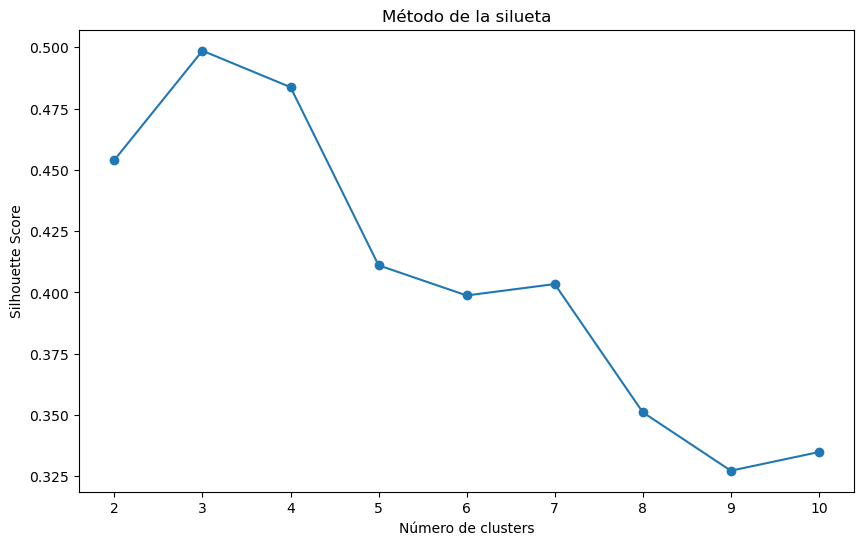

Número óptimo de clusters: 3


In [481]:
# Método de la silueta para determinar el número óptimo de clusters
def silhouette_method(data, max_clusters=10):
    silhouette_avg = []
    for k in range(2, max_clusters + 1):
        agg_clust = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = agg_clust.fit_predict(data)
        silhouette_avg.append(silhouette_score(data, labels))
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_avg, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Método de la silueta')
    plt.show()
    return silhouette_avg

# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_1[cl_var_norm])

# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
n_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {n_clusters}")

Text(0.5, 1.0, 'Clusters Demográficos sin restricción espacial, AHC ($k=3$)')

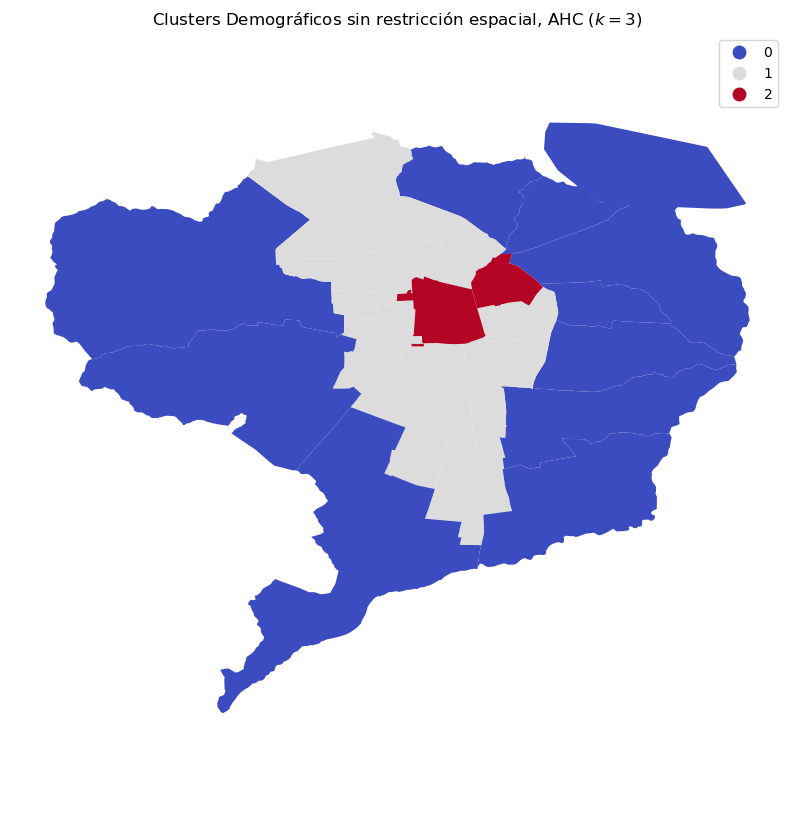

In [482]:
AHC = AgglomerativeClustering( n_clusters=n_clusters)
# Run clustering
AHC.fit(cead_comunas_1[cl_var_norm])
# Assignar etiquetas al dataframe
cead_comunas_1['ahc'] =AHC.labels_

f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='ahc', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos sin restricción espacial, AHC ($k=%d$)'%n_clusters)

In [483]:

w = weights.Queen.from_dataframe(cead_comunas_1)
w.transform ='R'
w.islands

[]

In [484]:
AHC_spatial = AgglomerativeClustering(connectivity=w.sparse,n_clusters=n_clusters)
AHC_spatial.fit(cead_comunas_1[cl_var_norm])
cead_comunas_1['ahc_spatial'] =AHC_spatial.labels_

Text(0.5, 1.0, 'Clusters Demográficos con restricción espacial, AHC ($k=3$)')

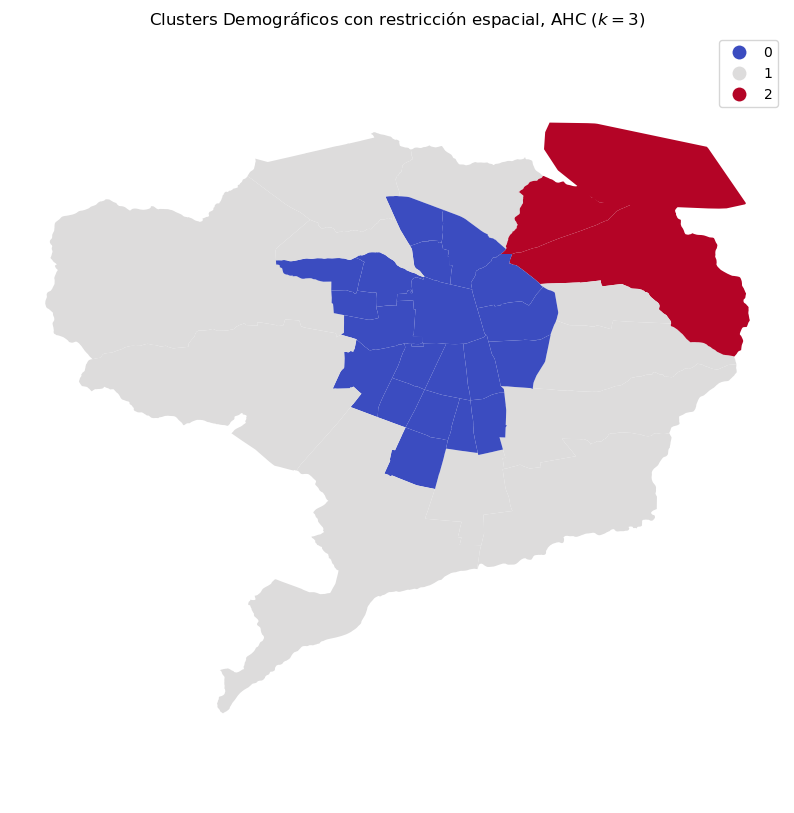

In [485]:
f,ax1= plt.subplots(1,1, figsize=(10,10))

# Asignar etiquetas de clustering a una columna
cead_comunas_1.plot(column='ahc_spatial', categorical=True, legend=True, linewidth=0, ax=ax1, cmap='coolwarm')
ax1.set_axis_off()
plt.axis('equal')
ax1.set_title(r'Clusters Demográficos con restricción espacial, AHC ($k=%d$)'%n_clusters)

In [486]:
from sklearn.metrics import pairwise as skm
import numpy 

spanning_forest_kwds = dict(dissimilarity=skm.euclidean_distances,affinity=None,reduction=numpy.sum,center=numpy.mean,verbose=2)

n_clusters=n_clusters
floor = 10
trace = False
islands = "increase"
attrs_name=cl_var_norm

Computing Affinity Kernel took 0.00s
Computing initial MST took 0.00s
Computing connected components took 0.00s.


finding cut...:   0%|          | 0/33 [00:00<?, ?it/s]

making cut deletion(in_node=24, out_node=25, score=35.79489351884547)...


finding cut...:   0%|          | 0/32 [00:00<?, ?it/s]

making cut deletion(in_node=11, out_node=7, score=33.59401327282862)...


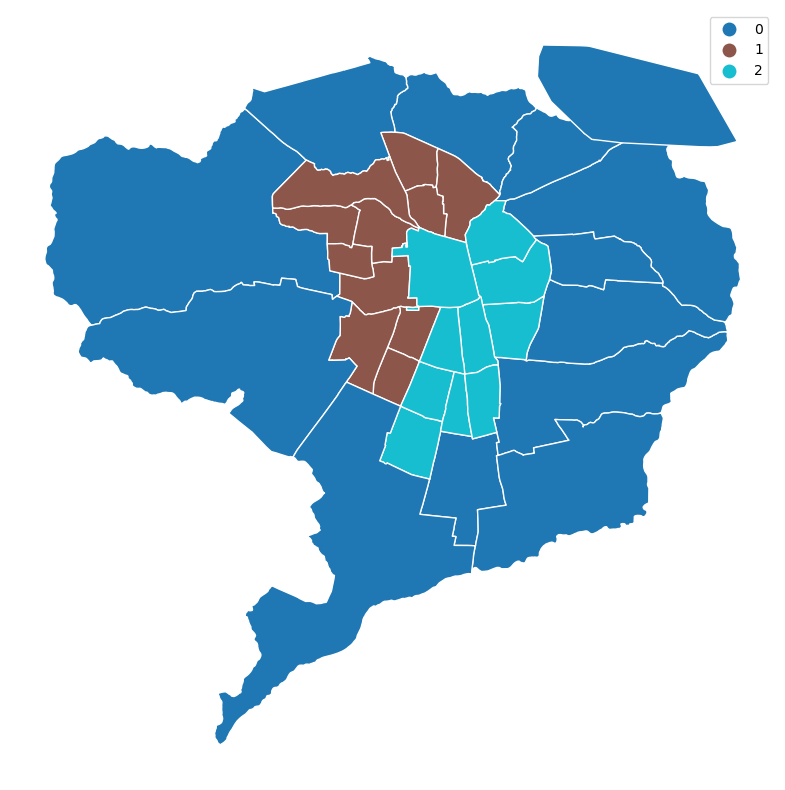

In [487]:
#Definición del modelo
model = spopt.region.Skater(cead_comunas_1,w,attrs_name,n_clusters=n_clusters,
                            floor=floor,trace=trace,islands=islands,
                            spanning_forest_kwds=spanning_forest_kwds)

#Resolver
model.solve()

#Graficar
cead_comunas_1["skater"] = model.labels_
cead_comunas_1.plot(figsize=(10,10), column="skater", legend=True,categorical=True, edgecolor="w").axis("off");

In [488]:
#¿Cuáles son las características de cada región?
regions = cead_comunas_1.groupby('skater').mean()[attrs_name]
regions.T

skater                   0         1         2
mean_cead_norm   -0.920247  0.347646  0.813911
mean_endisi_norm -1.111590  0.755022  0.614543
icvu_2017_norm    0.388068 -0.723609  0.291481

In [489]:
from sklearn import metrics 
ch_score = metrics.calinski_harabasz_score(cead_comunas_1[attrs_name],cead_comunas_1['skater'],)
print('CH score:',ch_score)

sil_score=metrics.silhouette_score(cead_comunas_1[attrs_name],cead_comunas_1['skater'])
print('Silhouette score:',sil_score)


CH score: 17.192708288619958
Silhouette score: 0.21896086941074344


In [490]:
cead_comunas_1

NOM_COMUNA    mean_cead  mean_endisi  \
0              PUDAHUEL    52.021462    -0.063794   
1           CERRO NAVIA   447.734155     0.223785   
2            HUECHURABA   109.796284    -0.115758   
3              CONCHALÍ   497.670377     0.232175   
4            LA PINTANA   252.774863     0.068546   
5             EL BOSQUE   480.244988     0.241533   
6      ESTACIÓN CENTRAL   767.731070     0.193388   
7   PEDRO AGUIRRE CERDA   494.801311     0.258775   
8              RECOLETA   663.027390     0.148521   
9         INDEPENDENCIA   698.362550     0.217126   
10            LO ESPEJO   519.278278     0.290331   
11          LA CISTERNA   540.638927     0.216872   
12           LA FLORIDA   258.864120    -0.056246   
13            PEÑALOLÉN   166.707645    -0.092658   
14           LAS CONDES   108.519480    -0.140721   
15             LA REINA   192.995422    -0.085764   
16             VITACURA   129.886884    -0.156501   
17        QUINTA NORMAL   571.384471     0.229005   
18             LO PRADO   654.788562     0.268494   
19            CERRILLOS   299.741394     0.198729   
20                MAIPÚ   131.706846    -0.020483   
21                MACUL   399.262931     0.189166   
22                ÑUÑOA   580.524007     0.093044   
23          PUENTE ALTO   281.213359     0.008347   
24            QUILICURA   152.029882     0.105423   
25                RENCA   260.712188     0.161087   
26         SAN BERNARDO   104.285342    -0.035186   
27          SAN JOAQUÍN   421.288019     0.266740   
28           SAN MIGUEL   701.839255     0.209898   
29            SAN RAMÓN   617.977079     0.291700   
30            LA GRANJA   531.096013     0.280208   
31          PROVIDENCIA   935.936012     0.015877   
32             SANTIAGO  1535.344408     0.184764   
33         LO BARNECHEA    42.897329    -0.206643   

                                             geometry  icvu_2017  \
0   POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...       36.2   
1   POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...       26.9   
2   POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...       37.2   
3   POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...       30.7   
4   POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...       24.2   
5   POLYGON ((-70.65469 -33.54858, -70.65469 -33.5...       28.0   
6   POLYGON ((-70.67958 -33.44384, -70.67958 -33.4...       33.4   
7   POLYGON ((-70.65563 -33.47835, -70.65571 -33.4...       26.4   
8   POLYGON ((-70.62020 -33.39746, -70.62017 -33.3...       32.3   
9   POLYGON ((-70.66093 -33.39982, -70.66092 -33.3...       30.0   
10  POLYGON ((-70.68305 -33.50624, -70.68297 -33.5...       24.1   
11  POLYGON ((-70.65213 -33.54481, -70.65212 -33.5...       32.8   
12  POLYGON ((-70.45620 -33.49483, -70.45561 -33.4...       38.9   
13  POLYGON ((-70.56202 -33.46251, -70.56149 -33.4...       38.8   
14  POLYGON ((-70.47951 -33.36433, -70.47940 -33.3...       73.6   
15  POLYGON ((-70.53882 -33.43062, -70.53883 -33.4...       52.4   
16  POLYGON ((-70.57395 -33.35432, -70.57391 -33.3...       71.6   
17  POLYGON ((-70.70646 -33.40781, -70.70616 -33.4...       30.1   
18  POLYGON ((-70.72880 -33.43641, -70.72878 -33.4...       30.0   
19  POLYGON ((-70.71265 -33.48103, -70.71249 -33.4...       32.6   
20  POLYGON ((-70.77557 -33.45816, -70.77547 -33.4...       46.4   
21  POLYGON ((-70.57651 -33.46984, -70.57653 -33.4...       47.8   
22  POLYGON ((-70.57808 -33.43609, -70.57799 -33.4...       54.2   
23  POLYGON ((-70.50386 -33.54574, -70.50373 -33.5...       36.9   
24  POLYGON ((-70.69284 -33.32358, -70.69279 -33.3...       39.6   
25  POLYGON ((-70.69355 -33.38135, -70.69349 -33.3...       36.4   
26  POLYGON ((-70.69294 -33.55581, -70.69301 -33.5...       28.9   
27  POLYGON ((-70.62322 -33.47457, -70.62321 -33.4...       38.2   
28  POLYGON ((-70.64197 -33.47650, -70.64191 -33.4...       43.4   
29  POLYGON ((-70.63742 -33.51877, -70.63723 -33.5...       35.5   
30  POLYGON ((-70.60986 -33.53743, -70.60981 -33.

In [491]:
raise Exception("No correr el siguiente bloque")

Exception: No correr el siguiente bloque

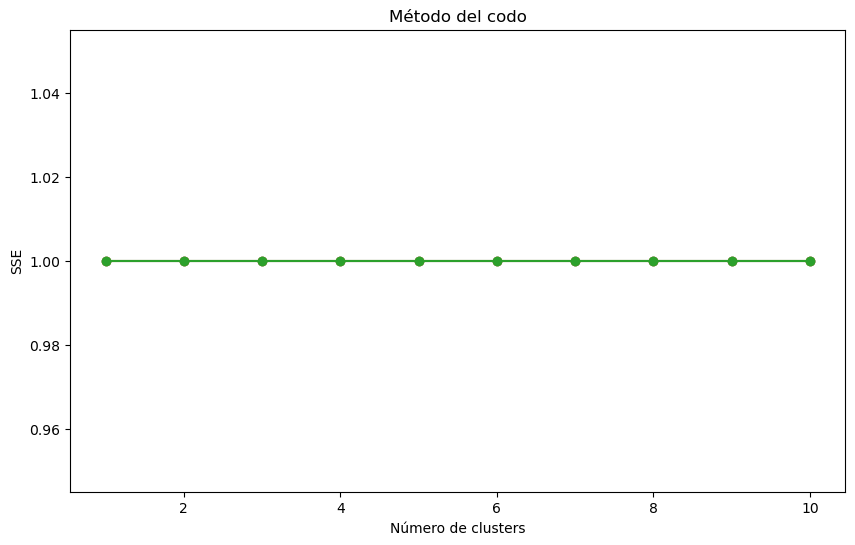

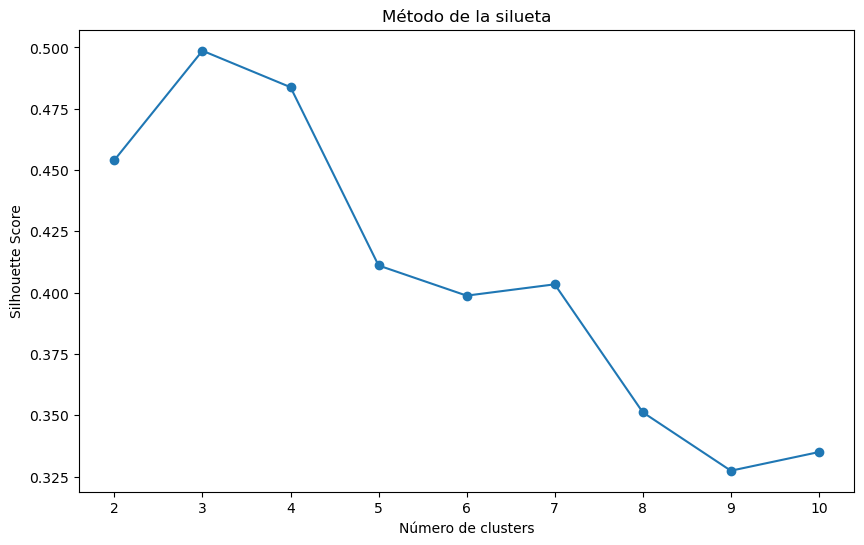

In [ ]:


# Asume que cead_comunas_1 ya está preparado y contiene las columnas normalizadas
# features = list(map(str, range(start_year, end_year + 1))) + columnas_icvu[1:]  + list(f'mean_endisi_{year}' for year in range(start_year, end_year + 1))
features = ["mean_cead", "mean_endisi", "icvu_2017"]
scaler = StandardScaler()
cead_comunas_1[features] = scaler.fit_transform(cead_comunas_1[features])

# Método de la silueta para determinar el número óptimo de clusters
def silhouette_method(data, max_clusters=10):
    silhouette_avg = []
    for k in range(2, max_clusters + 1):
        agg_clust = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = agg_clust.fit_predict(data)
        silhouette_avg.append(silhouette_score(data, labels))
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), silhouette_avg, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Método de la silueta')
    plt.show()
    return silhouette_avg

# Aplicar método de la silueta
silhouette_scores = silhouette_method(cead_comunas_1[features])

# Seleccionar el número óptimo de clusters basado en la puntuación de la silueta
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 porque el rango comienza en 2

print(f"Número óptimo de clusters: {optimal_clusters}")

In [ ]:
features

['mean_cead', 'mean_endisi', 'icvu_2017']

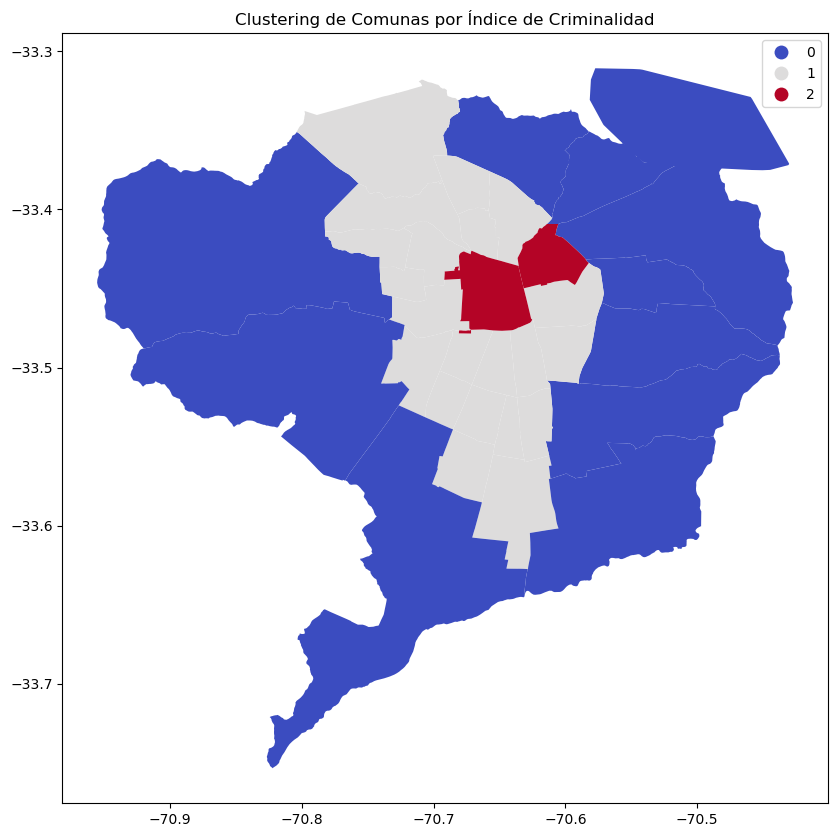

In [ ]:
# Clustering aglomerativo sin restricciones espaciales
agg_clust = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
cead_comunas_1['cluster_no_restrictions'] = agg_clust.fit_predict(cead_comunas_1[features])

# Visualizar los clusters en el mapa
cead_comunas_1.plot(column='cluster_no_restrictions', categorical=True, legend=True, linewidth=0, cmap='coolwarm', figsize=(10, 10))
plt.title('Clustering de Comunas por Índice de Criminalidad')
plt.show()

In [ ]:
#librerías para regionalización

from libpysal import weights
#!pip install spopt
import spopt
w = weights.Queen.from_dataframe(cead_comunas_1)
w.transform ='R'
w.islands

In [ ]:
w = weights.Queen.from_dataframe(cead_comunas_1)
w.transform ='R'
w.islands

[]

In [ ]:
AHC_spatial = AgglomerativeClustering(connectivity=w.sparse,n_clusters=optimal_clusters)
AHC_spatial.fit(cead_comunas_1[features])
db['ahc_spatial'] =AHC_spatial.labels_

NameError: name 'wei' is not defined

In [ ]:
raise Exception("No correr el código de abajo")

Exception: No correr el código de abajo

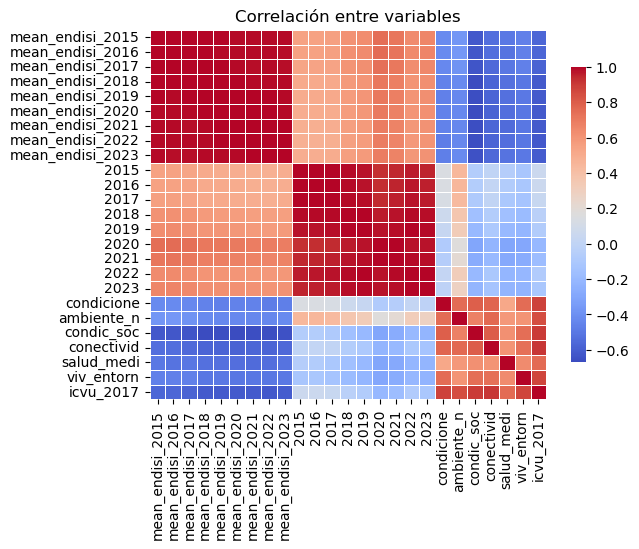

In [ ]:
corr = cead_comunas_1.corr()
sns.heatmap(corr, square=False, linewidths=.5, cbar_kws={"shrink": .8},cmap='coolwarm');
plt.title('Correlación entre variables')
plt.show()

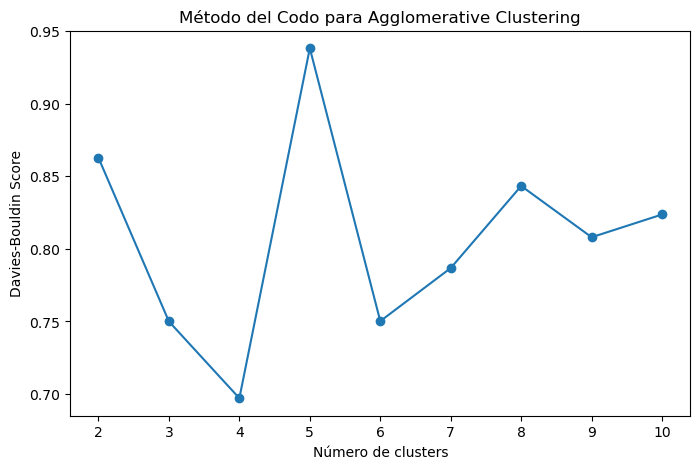

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

# Suponiendo que ya has cargado y procesado tu geodataframe como cead_comunas_1
# Seleccionar las columnas de los años para el clustering
# data_for_clustering = cead_comunas_1[list(str(year) for year in range(start_year, end_year + 1))]
# data_for_clustering todas las columnas menos la de geometría y la de nombre de la comuna
data_for_clustering = cead_comunas_1.copy().drop(columns=['geometry', 'NOM_COMUNA'])


# Normalizar los datos
scaler = StandardScaler()
cead_comunas_1_scaled = scaler.fit_transform(data_for_clustering)

# Método del codo para Agglomerative Clustering usando Davies-Bouldin Score
db_scores = []
k_range = range(2, 11)  # Probar de 2 a 10 clusters

for k in k_range:
    agg_cluster = AgglomerativeClustering(n_clusters=k)
    labels = agg_cluster.fit_predict(cead_comunas_1_scaled)
    db_score = davies_bouldin_score(cead_comunas_1_scaled, labels)
    db_scores.append(db_score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Método del Codo para Agglomerative Clustering')
plt.show()

In [ ]:
raise Exception("No correr el código de abajo")

Exception: No correr el código de abajo

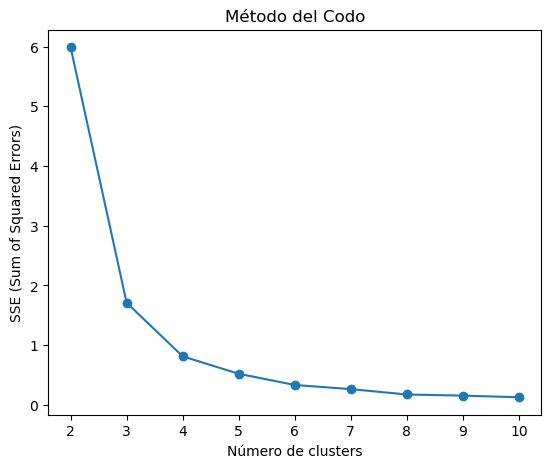

2015        2016        2017        2018        2019        2020  \
0   80.853367   72.721897   66.481350   70.303749   74.247815   51.166407   
1  520.934755  546.886875  485.611035  532.559142  524.268881  434.878244   
2  165.618737  147.667056  147.132514  137.488497  136.263506   97.152896   
3  685.883211  622.965578  650.238887  740.609851  700.104937  541.775728   
4  346.388696  332.366324  302.252707  304.748492  321.989113  242.321026   

         2021        2022        2023  
0   53.290525   64.433274   70.841115  
1  454.342334  559.412378  658.985619  
2   96.440174  111.741421  118.556823  
3  471.477200  551.316886  612.614322  
4  224.653495  267.902823  271.219590

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Seleccionar las columnas de los años para el clustering
data_for_clustering = cead_comunas_1[list(str(year) for year in range(start_year, end_year + 1))]
#data_for_clustering = cead_comunas_1[["2015"]]

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

# Método del codo
sse = []
silhouette_scores = []
k_range = range(2, 11)  # Probar de 2 a 10 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_normalized)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_normalized, kmeans.labels_))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Método del Codo')

plt.show()

display(data_for_clustering.head(5))




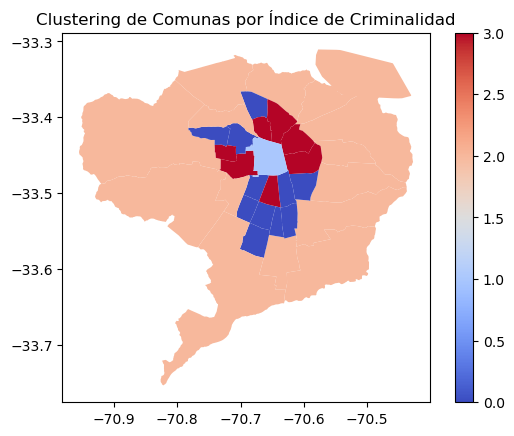

In [ ]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k)
cead_comunas_1['Cluster'] = kmeans.fit_predict(data_normalized)

# Visualizar los clusters en el mapa
cead_comunas_1.plot(column='Cluster', cmap='coolwarm', legend=True)
plt.title('Clustering de Comunas por Índice de Criminalidad')
plt.show()


In [ ]:
# Solo comuna de Santiago
cead_comunas_1[["NOM_COMUNA", "2015", "mean_endisi_2015", "Cluster"]].sort_values(by="2015")

# 0: Comunas con bajo índice de criminalidad
# 2: Comunas con índice de criminalidad medio
# 1: Comunas con alto índice de criminalidad
# 3: Comunas con muy alto índice de criminalidad

NOM_COMUNA         2015  mean_endisi_2015  Cluster
33         LO BARNECHEA    75.545066         -0.194884        2
0              PUDAHUEL    80.853367         -0.098868        2
26         SAN BERNARDO   132.957923         -0.054229        2
2            HUECHURABA   165.618737         -0.111830        2
14           LAS CONDES   188.295562         -0.127858        2
20                MAIPÚ   197.681325         -0.043427        2
24            QUILICURA   214.701915          0.104288        2
16             VITACURA   242.988061         -0.135990        2
13            PEÑALOLÉN   271.380007         -0.085872        2
15             LA REINA   320.290577         -0.073313        2
4            LA PINTANA   346.388696          0.072726        2
25                RENCA   356.465685          0.140442        2
12           LA FLORIDA   391.696692         -0.039368        2
19            CERRILLOS   396.968957          0.185588        2
23          PUENTE ALTO   416.189475          0.010179        2
27          SAN JOAQUÍN   501.596152          0.271603        0
1           CERRO NAVIA   520.934755          0.224280        0
21                MACUL   556.054117          0.199095        0
3              CONCHALÍ   685.883211          0.231258        0
10            LO ESPEJO   688.486768          0.281123        0
5             EL BOSQUE   705.718819          0.235241        0
17        QUINTA NORMAL   725.207903          0.226635        0
11          LA CISTERNA   737.738982          0.213906        0
7   PEDRO AGUIRRE CERDA   764.853288          0.259377        0
18             LO PRADO   817.829373          0.259163        3
30            LA GRANJA   818.796422          0.276345        0
29            SAN RAMÓN   840.036041          0.290683        0
22                ÑUÑOA   933.629092          0.107790        3
28           SAN MIGUEL   963.991624          0.215768        3
8              RECOLETA   989.504551          0.156514        3
9         INDEPENDENCIA  1082.053337          0.206690        3
6      ESTACIÓN CENTRAL  1280.614904          0.198534        3
31          PROVIDENCIA  1693.535643          0.030149        3
32             SANTIAGO  3006.409761          0.200654        1

In [ ]:
# Ver comuna con variación de criminalidad en el tiempo, usando max-min
cead_comunas_1["Variacion"] = cead_comunas_1[[str(year) for year in range(start_year, end_year + 1)]].max(axis=1) - cead_comunas_1[[str(year) for year in range(start_year, end_year + 1)]].min(axis=1)
cead_comunas_1[["NOM_COMUNA", "Variacion", "Cluster"]].sort_values(by="Variacion", ascending=False)

# Mostrar solo la comuna de santiago y providencia
cead_comunas_1[cead_comunas_1["NOM_COMUNA"].isin(["ESTACIÓN CENTRAL", "PUENTE ALTO"])][["NOM_COMUNA"]+[str(year) for year in range(start_year, end_year + 1)]]

NOM_COMUNA         2015         2016         2017         2018  \
6   ESTACIÓN CENTRAL  1280.614904  1337.187414  1535.400210  1319.212405   
23       PUENTE ALTO   416.189475   391.155096   411.078337   396.776215   

           2019        2020        2021        2022         2023  
6   1207.530467  754.184013  707.574396  930.589917  1140.159018  
23   393.772996  266.583842  259.228789  296.502702   297.953314

In [ ]:
ruta_cead_2 = r"Datos\CEAD\reportes-unidadTerritorial-100mil.xlsx"
cead_2 = pd.read_excel(ruta_cead_2, thousands=',', decimal='.')
cead_2 = cead_2.round(2)

# Convertir la columna "Unidad Territorial" a mayúsculas
cead_2['UNIDAD TERRITORIAL'] = cead_2['UNIDAD TERRITORIAL'].str.upper()

# Aplicar map a la columna "UNIDAD TERRITORIAL" para eliminar los espacios en blanco al principio y al final
cead_2['UNIDAD TERRITORIAL'] = cead_2['UNIDAD TERRITORIAL'].map(str.strip)

# Filtrar solo columnas de interés
cead_2 = cead_2[['UNIDAD TERRITORIAL'] + list(range(start_year, end_year + 1))]

display(cead_2.head(5))

UNIDAD TERRITORIAL      2015      2016      2017      2018      2019  \
0           SANTIAGO  22742.34  20764.52  22056.26  21146.91  17625.99   
1          CERRILLOS  11028.37  10862.37  10568.53  11578.81  11641.07   
2        CERRO NAVIA   6105.95   6591.47   6245.52   6643.15   6589.72   
3           CONCHALÍ   8142.21   7827.19   8222.91   8982.30   8691.91   
4          EL BOSQUE   8031.85   7114.92   8275.13   8230.04   7629.73   

       2020      2021      2022      2023  
0  10807.58  11976.30  12707.44  12915.58  
1   8612.12   8601.43   9833.29  10146.57  
2   5458.88   5557.82   6526.89   7955.56  
3   6755.27   5843.87   6219.80   7293.10  
4   5939.53   5385.09   5902.42   6278.44

In [ ]:
# Eliminar las filas que en la columna "Unidad Territorial" no estén en la lista de comunas
cead_2 = cead_2[cead_2["UNIDAD TERRITORIAL"].isin(m_comunas)]
cead_2 = cead_2.reset_index(drop=True)
display(cead_2.head(5))

UNIDAD TERRITORIAL      2015      2016      2017      2018      2019  \
0           SANTIAGO  22742.34  20764.52  22056.26  21146.91  17625.99   
1          CERRILLOS  11028.37  10862.37  10568.53  11578.81  11641.07   
2        CERRO NAVIA   6105.95   6591.47   6245.52   6643.15   6589.72   
3           CONCHALÍ   8142.21   7827.19   8222.91   8982.30   8691.91   
4          EL BOSQUE   8031.85   7114.92   8275.13   8230.04   7629.73   

       2020      2021      2022      2023  
0  10807.58  11976.30  12707.44  12915.58  
1   8612.12   8601.43   9833.29  10146.57  
2   5458.88   5557.82   6526.89   7955.56  
3   6755.27   5843.87   6219.80   7293.10  
4   5939.53   5385.09   5902.42   6278.44

In [ ]:
# Join de las cead_2 con las comunas
cead_comunas_2 = comunas.merge(cead_2, left_on='NOM_COMUNA', right_on='UNIDAD TERRITORIAL', how='inner')

# Eliminar la columna "Unidad Territorial"
cead_comunas_2 = cead_comunas_2.drop(columns=['UNIDAD TERRITORIAL'])

display(cead_comunas_2.head(5))

NOM_COMUNA                                           geometry  \
0     PUDAHUEL  POLYGON ((-70.78914 -33.36153, -70.78824 -33.3...   
1  CERRO NAVIA  POLYGON ((-70.71927 -33.41334, -70.71888 -33.4...   
2   HUECHURABA  POLYGON ((-70.66312 -33.32923, -70.66276 -33.3...   
3     CONCHALÍ  POLYGON ((-70.69041 -33.36579, -70.69028 -33.3...   
4   LA PINTANA  POLYGON ((-70.63212 -33.55817, -70.63204 -33.5...   

   mean_endisi_2015  mean_endisi_2016  mean_endisi_2017  mean_endisi_2018  \
0         -0.098868         -0.081216         -0.074662         -0.067701   
1          0.224280          0.242552          0.261091          0.219806   
2         -0.111830         -0.057266         -0.094771         -0.120563   
3          0.231258          0.260440          0.282941          0.249246   
4          0.072726          0.085928          0.117267          0.094583   

   mean_endisi_2019  mean_endisi_2020  mean_endisi_2021  mean_endisi_2022  \
0         -0.079220         -0.040010         -0.059132         -0.058857   
1          0.198873          0.208580          0.193865          0.206738   
2         -0.144225         -0.124776         -0.167283         -0.126357   
3          0.218385          0.218902          0.196848          0.194019   
4          0.058612          0.054557          0.000846          0.037702   

   mean_endisi_2023     2015     2016     2017     2018     2019     2020  \
0         -0.014481  9731.70  8918.37  8166.98  8837.91  9534.64  6927.81   
1          0.258278  6105.95  6591.47  6245.52  6643.15  6589.72  5458.88   
2         -0.094749  9957.12  9235.09  9252.42  8596.52  8633.59  6445.51   
3          0.237533  8142.21  7827.19  8222.91  8982.30  8691.91  6755.27   
4          0.094690  7992.08  7777.36  7341.60  7567.93  8013.86  6234.98   

      2021     2022     2023  
0  6657.26  7087.63  7897.62  
1  5557.82  6526.89  7955.56  
2  5731.61  6169.62  6831.40  
3  5843.87  6219.80  7293.10  
4  5702.18  6731.42  7251.35

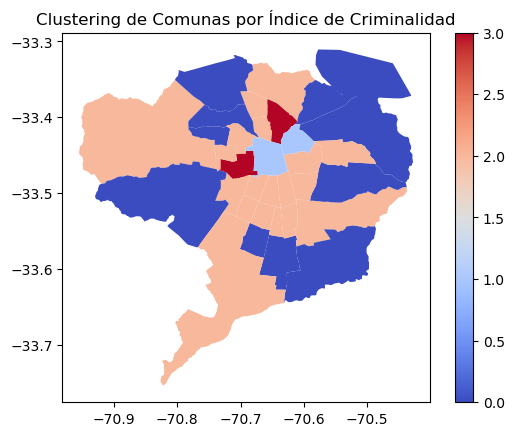

In [ ]:
# Seleccionar las columnas de los años para el clustering
data_for_clustering = cead_comunas_2[list(range(start_year, end_year + 1))]

# Normalizar los datos usando MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_for_clustering)

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k)
cead_comunas_2['Cluster'] = kmeans.fit_predict(data_normalized)

# Visualizar los clusters en el mapa
cead_comunas_2.plot(column='Cluster', cmap='coolwarm', legend=True)
plt.title('Clustering de Comunas por Índice de Criminalidad')
plt.show()
